In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\HP\AppData\Local\Temp\ipykernel_103360\2066994997.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = INTERVAL, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


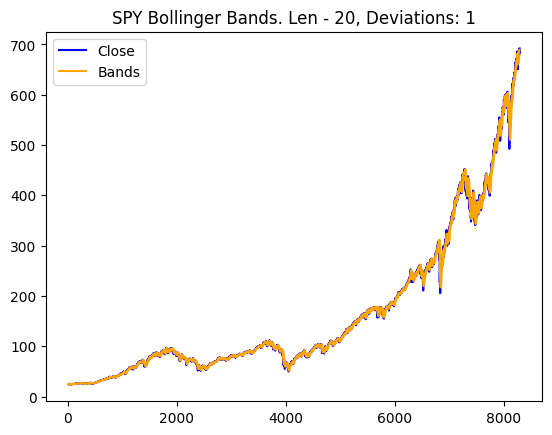

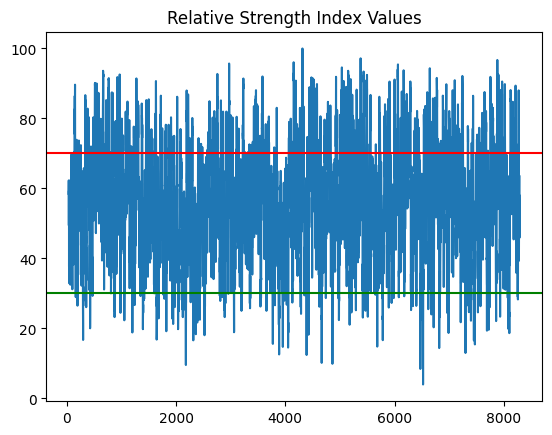

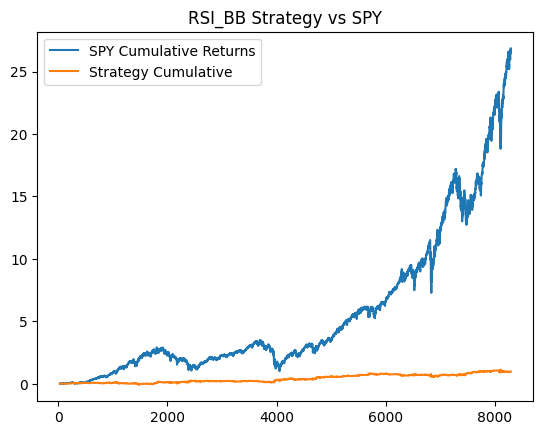

In [14]:
TICKER = 'SPY'
RSI_LENGTH = 14
MFI_LENGTH = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
LOOKBACK = 11000
INTERVAL = '1d'
BB_LEN = 20
DEVS = 1

#Set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

#what subsection of data are you interested in


def get_data(ticker = TICKER, lookback =  LOOKBACK, interval = INTERVAL):

    #get data at interval you want
    df = yf.download(ticker, interval = INTERVAL, period = PERIOD) 
    df.columns = df.columns.get_level_values(0)

    #reset the index to make plots prettier
    df = df.reset_index(drop = True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length = RSI_LENGTH, overbought= RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):
    price_change = df['Close'].diff()
    # separategains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0) #negative sign i crucial to factor in loss

    # average gain vs loss
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    rs= avg_gain/avg_loss
    rsi = 100 - (100 /(1 + rs))

    df['RSI'] = rsi

    #plot thenrelative strength 
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title('Relative Strength Index Values')

    return df.dropna()

def add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold= RSI_OVERSOLD):
    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1,
                     np.where(df['RSI'] < oversold, 1, 0))

    #shift back to make sure we have sen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_bollinger_bands(df, devs = DEVS, bb_len = BB_LEN):

    #can change to ema (use MACD video/ code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the periods
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color = 'blue')
    plt.plot(df['Upper_Band'], color = 'orange')
    plt.plot(df['Lower_Band'], color = 'orange')
    plt.legend(['Close', 'Bands'])
    plt.title(f'{TICKER} Bollinger Bands. Len - {BB_LEN}, Deviations: {devs}')

    return df.dropna()

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1,
                        np.where(df['Close'] < df['Lower_Band'], 1, 0))
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['RSI_Strategy'] + df['BB_Strategy']
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1,
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1+ df['Close']. pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1+ df['Close']. pct_change() * df['Strategy']).cumprod() - 1
   

#plot the strategy returns
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative Returns', 'Strategy Cumulative'])
    plt.title(f'RSI_BB Strategy vs {TICKER}')
    return df

def main():
    df = get_data(TICKER)
    df = add_bollinger_bands(df, devs = DEVS, bb_len = BB_LEN)
    df = add_RSI(df, length = RSI_LENGTH, overbought= RSI_OVERBOUGHT, oversold = RSI_OVERSOLD)
    df = add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold= RSI_OVERSOLD)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df
df = main()


In [7]:
df

Price,Close,High,Low,Open,Volume,BB_SMA,BB_STD,Upper_Band,Lower_Band,RSI,RSI_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
32,24.844854,24.965544,24.810372,24.965544,21800,24.681064,0.408752,25.907319,23.454808,58.474040,NaN,NaN,NaN,NaN,NaN,NaN
33,25.000034,25.103483,24.948310,24.948310,59300,24.733650,0.375848,25.861195,23.606106,61.416845,0.0,0.0,0.0,0.0,0.006246,0.000000
34,24.962196,25.100779,24.962196,25.100779,66900,24.780034,0.340618,25.801889,23.758180,62.302769,-1.0,0.0,-1.0,0.0,0.004723,0.000000
35,24.823626,24.875594,24.702366,24.719689,183400,24.815179,0.303220,25.724839,23.905520,50.788029,-1.0,0.0,-1.0,0.0,-0.000854,0.000000
36,24.875586,24.910231,24.840940,24.892908,55200,24.853785,0.252798,25.612178,24.095391,49.442512,0.0,0.0,0.0,0.0,0.001237,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,687.010010,688.559998,686.580017,687.450012,47160700,682.547134,5.351810,698.602565,666.491703,56.211297,0.0,0.0,0.0,0.0,26.652004,0.089732
8287,681.919983,687.359985,681.710022,687.140015,74144800,682.667029,5.307148,698.588473,666.745585,46.281283,0.0,0.0,0.0,0.0,26.447131,0.089732
8288,683.169983,686.869995,679.820007,685.710022,89377200,682.731772,5.304876,698.646401,666.817142,45.898018,0.0,0.0,0.0,0.0,26.497444,0.089732
8289,687.719971,689.429993,686.380005,686.539978,71927200,682.999088,5.419348,699.257131,666.741044,58.747526,0.0,0.0,0.0,0.0,26.680580,0.089732
